# Animal Classification

## Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as du
from torch.utils.data import Dataset
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import cv2 
import numpy as np
from tqdm import tqdm

## Loading Dataset

In [2]:
# https://www.kaggle.com/datasets/virtualdvid/oregon-wildlife
def load_dataset(data_path, save_data_path, image_size, saved=False):
    '''
    data_path: directory containing where images of the same label are stored in the same subfolder
    save_data_path: location to store processed dataset
    saved: if True, load array from save_data_path. If false, dataset needs to be created from data_path
    '''
    if(saved):
        with open(save_data_path, 'rb') as f:
            dataset = np.load(f)
            labels = np.load(f)
            return dataset, labels
    start_path = os.getcwd()
    os.chdir(data_path)
    dataset = []
    labels = []
    label_idx = 0
    folder_list = os.listdir('./')
    for folder in tqdm(folder_list):  # each folder stores one label
        os.chdir(folder)
        file_list = os.listdir('./')
        for file in file_list:   # iterating through each folder and saving img along with its label
            img = cv2.imread(file)
            if(img is not None): # save img if reading image is successful
                dataset.append(cv2.resize(img, image_size))
                labels.append(label_idx)
        label_idx += 1
        os.chdir("./..")
    os.chdir(start_path)
    dataset = np.array(dataset, dtype=np.uint8)
    labels = np.array(labels, dtype=np.uint8)
    with open(save_data_path, 'wb') as f:  # saving dataset because it takes a long time to generate it every time
        np.save(f, dataset, allow_pickle=True)
        np.save(f, labels, allow_pickle=True)
        return dataset, labels

In [3]:
def split_dataset(dataset, labels, split=np.array([.8,.1,.1])):
    '''
    dataset: features
    labels: labels
    split: train/val/test 
    returns a three tuples of (dataset, labels) for train/val/test splits
    '''
    assert(np.sum(split) == 1)
    split = np.cumsum(split)
    permutation = np.random.permutation(labels.shape[0])
    dataset = dataset[permutation]
    labels = labels[permutation]
    dataset = np.einsum("bijc->bcij", dataset)
    train_data = (dataset[:int(dataset.shape[0]*split[0])], labels[:int(dataset.shape[0]*split[0])])
    valid_data = (dataset[int(dataset.shape[0]*split[1]):int(dataset.shape[0]*split[2])], labels[int(dataset.shape[0]*split[1]):int(dataset.shape[0]*split[2])])
    test_data = (dataset[int(dataset.shape[0]*split[1]):], labels[int(dataset.shape[0]*split[1]):])
    return train_data, valid_data, test_data


## Preprocessing and displaying images

Size of Training Set 11160
Size of Validation Set 1396
Size of Testing Set 1396


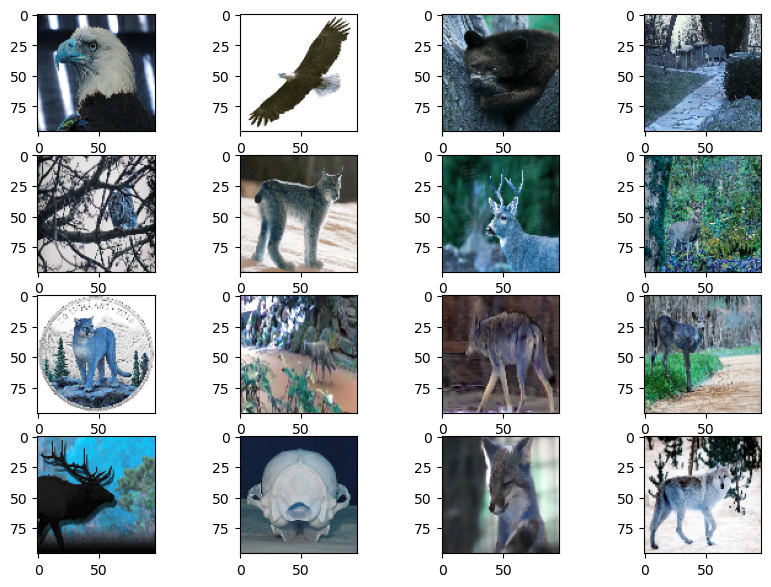

In [4]:
dataset, labels = load_dataset("./Datasets/oregon_wildlife", "./Datasets/wildlife_dataset.npy", (96, 96), True)
fig = plt.figure(figsize=(10, 7))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(dataset[i*500])
train_data, valid_data, test_data = split_dataset(dataset, labels)
print(f"Size of Training Set {train_data[0].shape[0]}")
print(f"Size of Validation Set {valid_data[0].shape[0]}")
print(f"Size of Testing Set {test_data[0].shape[0]}")

## Visualizing Dataset

## Dataset Class

In [5]:
class Image_Dataset(Dataset):
    def __init__(self, data, normalize=True, augment=False):
        '''
        data: tuple of (features, labels)
        '''
        super(Image_Dataset, self).__init__()
        self.images = torch.tensor(data[0], dtype=torch.float)
        if(normalize):
            self.images[:,0] = (self.images[:,0]-torch.mean(self.images[:,0])) / torch.std(self.images[:,0])
            self.images[:,1] = (self.images[:,1]-torch.mean(self.images[:,1])) / torch.std(self.images[:,1])
            self.images[:,2] = (self.images[:,2]-torch.mean(self.images[:,2])) / torch.std(self.images[:,2])
        self.labels = torch.tensor(data[1], dtype=torch.long)
        self.aug = transforms.RandomPerspective()
        self.augment = augment

    def __len__(self):
        '''return len of dataset'''
        return self.images.shape[0]
        
    def __getitem__(self, idx):
        '''return sequence, future sequence'''
        if(self.augment):
            return self.aug(self.images[idx]), self.labels[idx]
        return self.images[idx], self.labels[idx]

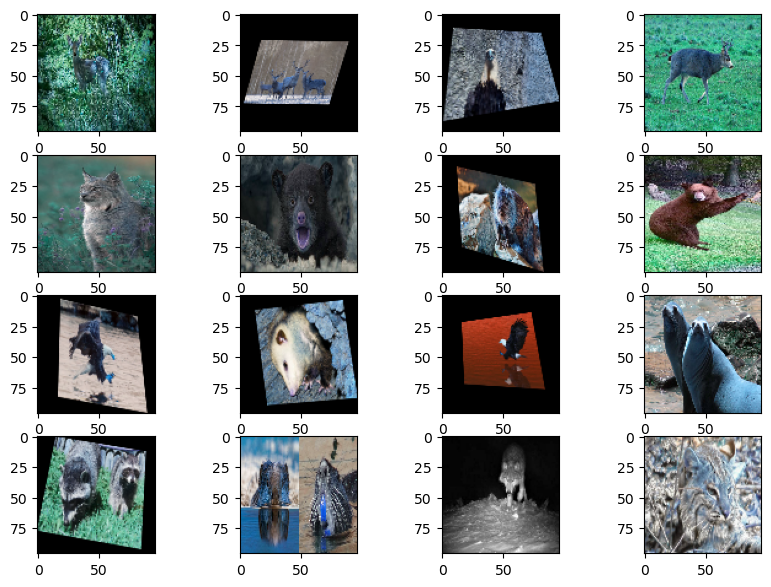

In [6]:
visualize_data = Image_Dataset(valid_data, normalize=False, augment=True)
fig = plt.figure(figsize=(10, 7))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    img = torch.einsum("cwh->whc", visualize_data[i][0]).type(torch.int)
    plt.imshow(img)

In [7]:
class CNN(nn.Module):
    def __init__(self, in_channels, num_classes, pretrain = False):
        '''
        in_dim: input layer dim
        hidden_layers: hidden layers in lstm
        '''
        super(CNN, self).__init__()
        self.flatten = nn.Flatten()
        if(pretrain == True):
            mobilenetv2 = models.mobilenet_v2(pretrained=True)
            self.backbone = nn.Sequential(*list(mobilenetv2.children())[:-1])
            for param in self.backbone.parameters():
                param.requires_grad = False
            self.linear = nn.Sequential(
                            nn.Linear(11520, 6000),
                            nn.ReLU(),
                            nn.Linear(6000, 1000),
                            nn.ReLU(),
                            nn.Linear(1000, 500),
                            nn.ReLU(),
                            nn.Linear(500, num_classes),
                        )
        else:
            cnn_stack = []
            cnn_stack.append(nn.Conv2d(3, 64, (5,5)))
            cnn_stack.append(nn.ReLU())
            cnn_stack.append(nn.Conv2d(64, 64, (5,5)))
            cnn_stack.append(nn.ReLU())
            cnn_stack.append(nn.MaxPool2d((3,3)))
            cnn_stack.append(nn.Conv2d(64, 128, (4,4)))
            cnn_stack.append(nn.ReLU())
            cnn_stack.append(nn.Conv2d(128, 128, (3,3)))
            cnn_stack.append(nn.ReLU())
            cnn_stack.append(nn.Conv2d(128, 128, (3,3)))
            cnn_stack.append(nn.ReLU())
            cnn_stack.append(nn.MaxPool2d((3,3)))
            self.backbone = nn.Sequential(*cnn_stack)
            self.linear = nn.Sequential(
                            nn.Linear(6272, 1000),
                            nn.ReLU(),
                            nn.Linear(1000, 500),
                            nn.ReLU(),
                            nn.Linear(500, num_classes),
                        )
    def forward(self, x):
        x = self.flatten(self.backbone(x))
        x = self.linear(x)

        return x

In [8]:
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f"using device: {device}")

# hyper parameters
batch_size = 64
learning_rate = 1e-4
epochs = 40
in_channels = 3
num_classes = 20

#initializing model and optimizer
model = CNN(in_channels, num_classes, False)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loader = du.DataLoader(dataset=Image_Dataset(train_data, augment=True),
                             batch_size=batch_size,
                             shuffle=True)
valid_loader = du.DataLoader(dataset=Image_Dataset(valid_data),
                             batch_size=batch_size,
                             shuffle=True)
test_loader = du.DataLoader(dataset=Image_Dataset(test_data),
                             batch_size=batch_size,
                             shuffle=True)

# sending model to device
model.to(device)
# set model to training mode
model.train()

using device: cuda:0


CNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU()
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Sequential(
    (0): Linear(in_features=6272, out_features=1000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1000, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=20, bias=True)
  )
)

## Training Hand Crafted Model

In [9]:
train_loss_list = []
valid_loss_list = []
valid_acc_list = []
# iterating through all epochs
for epoch in range(1, epochs+ 1):    
    # training step
    train_loss = 0.
    model.train()

    # iterating through entire dataset in batches
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):

        # sending batch over to device
        data, target = data.to(device).type(torch.float), target.to(device)

        # zeroing out previous gradients
        optimizer.zero_grad()

        # getting predictions from model
        output = model(data)

        # claculating cross entropyloss
        loss = F.cross_entropy(output, target)

        train_loss += loss.item()

        # Gradient Descent and Backprop
        loss.backward()
        optimizer.step()
    
    # validation step
    valid_loss = 0

    # turning off gradient for validation step
    model.eval()
    valid_loss = 0
    valid_acc = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(tqdm(valid_loader)):
            data, target = data.to(device).to(torch.float), target.to(device)
            output = model(data)
            loss = F.cross_entropy(output, target)
            valid_loss += loss.item()
            output = F.softmax(output, dim=-1)
            pred = torch.argmax(output, dim=-1)
            correct = torch.sum(pred == target, dtype=torch.float)
            valid_acc += correct
    
    train_loss /= len(train_loader.dataset)
    valid_loss /= len(valid_loader.dataset)
    valid_acc /= len(valid_loader.dataset)
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc.detach().cpu().numpy())

    # printing loss per epoch
    print(f"Epoch: {epoch}, Training Loss: {train_loss}, Validation Loss: {valid_loss}, Validation Accuracy: {valid_acc}")

100%|██████████| 22/22 [00:01<00:00, 15.78it/s]


Epoch: 1, Training Loss: 0.04341680307114851, Validation Loss: 0.04037043887769595, Validation Accuracy: 0.1948424130678177


100%|██████████| 22/22 [00:01<00:00, 15.42it/s]


Epoch: 2, Training Loss: 0.03947905588320934, Validation Loss: 0.038017617255705474, Validation Accuracy: 0.26575931906700134


100%|██████████| 22/22 [00:01<00:00, 11.92it/s]


Epoch: 3, Training Loss: 0.03750530412974751, Validation Loss: 0.03641527173853877, Validation Accuracy: 0.29441261291503906


100%|██████████| 22/22 [00:01<00:00, 11.62it/s]


Epoch: 4, Training Loss: 0.035299445907702155, Validation Loss: 0.034567276949868844, Validation Accuracy: 0.34240689873695374


100%|██████████| 22/22 [00:01<00:00, 11.88it/s]


Epoch: 5, Training Loss: 0.033089053363782955, Validation Loss: 0.03265143849788218, Validation Accuracy: 0.37106019258499146


100%|██████████| 22/22 [00:01<00:00, 12.09it/s]


Epoch: 6, Training Loss: 0.030785164386568104, Validation Loss: 0.03048075637366505, Validation Accuracy: 0.42335245013237


100%|██████████| 22/22 [00:01<00:00, 11.98it/s]


Epoch: 7, Training Loss: 0.028255945027515453, Validation Loss: 0.027190444206440005, Validation Accuracy: 0.4871060252189636


100%|██████████| 22/22 [00:01<00:00, 12.16it/s]


Epoch: 8, Training Loss: 0.02546270851806928, Validation Loss: 0.025677251696245035, Validation Accuracy: 0.5121776461601257


100%|██████████| 22/22 [00:01<00:00, 11.21it/s]


Epoch: 9, Training Loss: 0.022918282390495356, Validation Loss: 0.02433591133202386, Validation Accuracy: 0.5494269728660583


100%|██████████| 22/22 [00:01<00:00, 11.52it/s]


Epoch: 10, Training Loss: 0.020142303230941936, Validation Loss: 0.021515402505254334, Validation Accuracy: 0.6189112067222595


100%|██████████| 22/22 [00:01<00:00, 12.11it/s]


Epoch: 11, Training Loss: 0.017850320030497822, Validation Loss: 0.01959143583275869, Validation Accuracy: 0.6640401482582092


100%|██████████| 22/22 [00:01<00:00, 11.64it/s]


Epoch: 12, Training Loss: 0.01555391302779584, Validation Loss: 0.02029289830379978, Validation Accuracy: 0.6511461734771729


100%|██████████| 22/22 [00:01<00:00, 12.14it/s]


Epoch: 13, Training Loss: 0.013756558897247452, Validation Loss: 0.017494092441903145, Validation Accuracy: 0.7177650928497314


100%|██████████| 22/22 [00:01<00:00, 11.78it/s]


Epoch: 14, Training Loss: 0.01209605934105039, Validation Loss: 0.017743245450336818, Validation Accuracy: 0.7249283790588379


100%|██████████| 22/22 [00:01<00:00, 11.76it/s]


Epoch: 15, Training Loss: 0.010930837634750591, Validation Loss: 0.016113563390037732, Validation Accuracy: 0.7664756774902344


100%|██████████| 22/22 [00:01<00:00, 12.01it/s]


Epoch: 16, Training Loss: 0.009789190403983584, Validation Loss: 0.015368176864348031, Validation Accuracy: 0.7987106442451477


100%|██████████| 22/22 [00:01<00:00, 11.96it/s]


Epoch: 17, Training Loss: 0.009045461355625088, Validation Loss: 0.015403486916363068, Validation Accuracy: 0.7922636270523071


100%|██████████| 22/22 [00:01<00:00, 12.19it/s]


Epoch: 18, Training Loss: 0.008371592499983354, Validation Loss: 0.01546373280208227, Validation Accuracy: 0.8008596301078796


100%|██████████| 22/22 [00:01<00:00, 11.96it/s]


Epoch: 19, Training Loss: 0.007644094784467024, Validation Loss: 0.015449933771759187, Validation Accuracy: 0.8030086159706116


100%|██████████| 22/22 [00:01<00:00, 11.88it/s]


Epoch: 20, Training Loss: 0.006820381817317778, Validation Loss: 0.01523247899162052, Validation Accuracy: 0.8173352479934692


100%|██████████| 22/22 [00:01<00:00, 11.50it/s]


Epoch: 21, Training Loss: 0.00670309151693057, Validation Loss: 0.01509682819204549, Validation Accuracy: 0.8209169507026672


100%|██████████| 22/22 [00:01<00:00, 11.91it/s]


Epoch: 22, Training Loss: 0.006414411593508976, Validation Loss: 0.01484253413356136, Validation Accuracy: 0.8295129537582397


100%|██████████| 22/22 [00:01<00:00, 12.03it/s]


Epoch: 23, Training Loss: 0.005844115768308921, Validation Loss: 0.015237797105039088, Validation Accuracy: 0.8094556331634521


100%|██████████| 22/22 [00:01<00:00, 11.75it/s]


Epoch: 24, Training Loss: 0.0057964463321004715, Validation Loss: 0.015544832179744469, Validation Accuracy: 0.8101719617843628


100%|██████████| 22/22 [00:01<00:00, 11.58it/s]


Epoch: 25, Training Loss: 0.00528242529293115, Validation Loss: 0.016086217581713438, Validation Accuracy: 0.8295129537582397


100%|██████████| 22/22 [00:01<00:00, 11.51it/s]


Epoch: 26, Training Loss: 0.005054103810086473, Validation Loss: 0.01707633189792961, Validation Accuracy: 0.8101719617843628


100%|██████████| 22/22 [00:01<00:00, 11.86it/s]


Epoch: 27, Training Loss: 0.004786551092821424, Validation Loss: 0.016491492660476007, Validation Accuracy: 0.8187679648399353


100%|██████████| 22/22 [00:01<00:00, 11.96it/s]


Epoch: 28, Training Loss: 0.0046053779748765795, Validation Loss: 0.016080031464981145, Validation Accuracy: 0.8323782682418823


100%|██████████| 22/22 [00:01<00:00, 11.57it/s]


Epoch: 29, Training Loss: 0.004417659890066873, Validation Loss: 0.015698879145961096, Validation Accuracy: 0.8323782682418823


100%|██████████| 22/22 [00:01<00:00, 11.99it/s]


Epoch: 30, Training Loss: 0.004165089875459671, Validation Loss: 0.01523447134945659, Validation Accuracy: 0.8388252258300781


100%|██████████| 22/22 [00:01<00:00, 11.70it/s]


Epoch: 31, Training Loss: 0.004169346410847907, Validation Loss: 0.018010332966943866, Validation Accuracy: 0.8280802369117737


100%|██████████| 22/22 [00:01<00:00, 11.63it/s]


Epoch: 32, Training Loss: 0.003935536312934105, Validation Loss: 0.01605818111097232, Validation Accuracy: 0.8352435827255249


100%|██████████| 22/22 [00:01<00:00, 11.71it/s]


Epoch: 33, Training Loss: 0.003764779319299058, Validation Loss: 0.016099218481932808, Validation Accuracy: 0.8316619396209717


100%|██████████| 22/22 [00:01<00:00, 11.91it/s]


Epoch: 34, Training Loss: 0.0038132824183952424, Validation Loss: 0.015779085841595614, Validation Accuracy: 0.8302292823791504


100%|██████████| 22/22 [00:01<00:00, 11.59it/s]


Epoch: 35, Training Loss: 0.003601790599084349, Validation Loss: 0.015899872007035253, Validation Accuracy: 0.8359599113464355


100%|██████████| 22/22 [00:01<00:00, 15.71it/s]


Epoch: 36, Training Loss: 0.003315862476505259, Validation Loss: 0.016650618979958204, Validation Accuracy: 0.8302292823791504


100%|██████████| 22/22 [00:01<00:00, 12.06it/s]


Epoch: 37, Training Loss: 0.003425053958397185, Validation Loss: 0.01668444346305634, Validation Accuracy: 0.8373925685882568


100%|██████████| 22/22 [00:01<00:00, 12.14it/s]


Epoch: 38, Training Loss: 0.0032159687799324806, Validation Loss: 0.01594162439890099, Validation Accuracy: 0.8395415544509888


100%|██████████| 22/22 [00:01<00:00, 11.45it/s]


Epoch: 39, Training Loss: 0.0032233538893869274, Validation Loss: 0.016854383195496904, Validation Accuracy: 0.8295129537582397


100%|██████████| 22/22 [00:02<00:00, 10.74it/s]

Epoch: 40, Training Loss: 0.00293305474283394, Validation Loss: 0.016374434389835785, Validation Accuracy: 0.8402578830718994


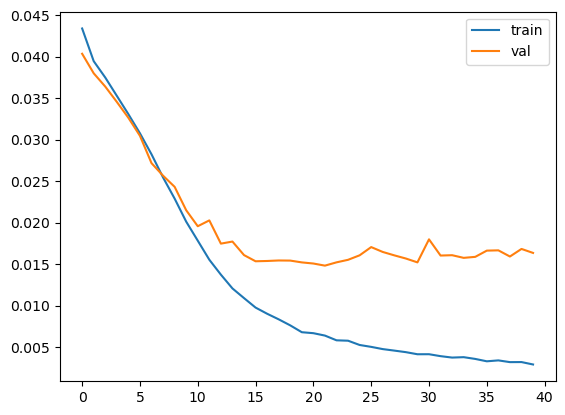

In [10]:
plt.plot(train_loss_list, label="train")
plt.plot(valid_loss_list, label="val")
plt.legend()
plt.show()

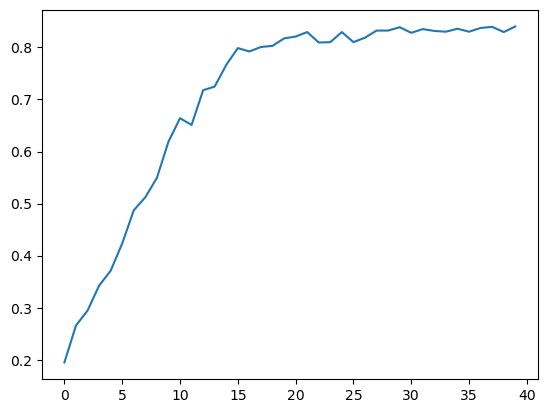

In [11]:
plt.plot(valid_acc_list)
plt.show()

In [12]:
test_loss = 0.
test_acc = 0.
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tqdm(test_loader)):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = F.cross_entropy(output, target)
        test_loss += loss.item()
        output = F.softmax(output, dim=-1)
        pred = torch.argmax(output, dim=-1)
        correct = torch.sum(pred == target, dtype=torch.float)
        test_acc += correct

test_loss /= len(test_loader.dataset)
test_acc /= len(test_loader.dataset)

# printing loss per epoch
print(f"Epoch: {epoch}, test loss: {test_loss}, test accuracy: {test_acc}")

100%|██████████| 22/22 [00:01<00:00, 11.84it/s]

Epoch: 40, test loss: 0.016308785317449653, test accuracy: 0.8402578830718994


## Write Up
By applying random perseption transformations to my dataset, I was able to increase the test accuracy from 80% to 84%. However, the downside is that I have to train much longer for the validation loss to ensure that the validation loss converges. Since the training dataset was different in every epoch due to the random augmentation, the loss and accuracy curve is not as smooth as the baseline model's. This suggests that training on the augmented dataset is more unstable than the baseline model's.  